# EECS 219 Project 1

### Import Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk import pos_tag
from nltk import RegexpParser
import string
import collections
import nltk
from nltk.stem import *
stemmer = PorterStemmer()
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import random
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


data=pd.read_csv("Project1-Classification.csv")
data.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports


In [2]:
data.shape

(3150, 8)

# Question 1:
### Overview: 
#### There are 3150 rows and 8 columns. 

### Histograms: 

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

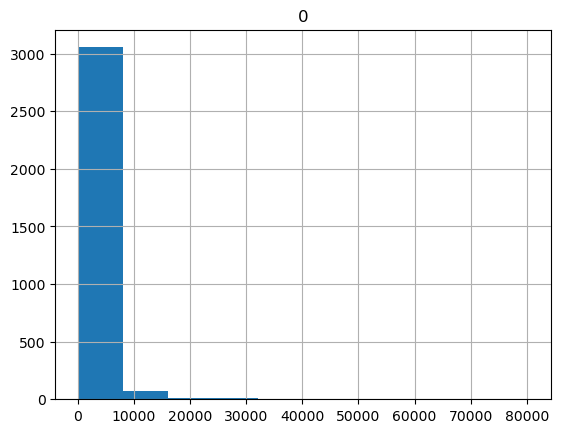

In [3]:
count=[]
for row in data['full_text']:
    countForRow=0
    for c in row:
        if c.isalnum():
            countForRow+=1
    count.append(countForRow)
# q1 histogram (a)
countHist=pd.DataFrame(count)
countHist.hist()        

<AxesSubplot:>

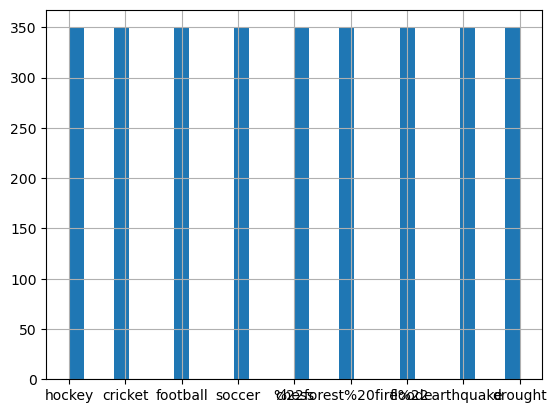

In [4]:
# q1 histogram (b)
data['leaf_label'].hist(bins=30)

<AxesSubplot:>

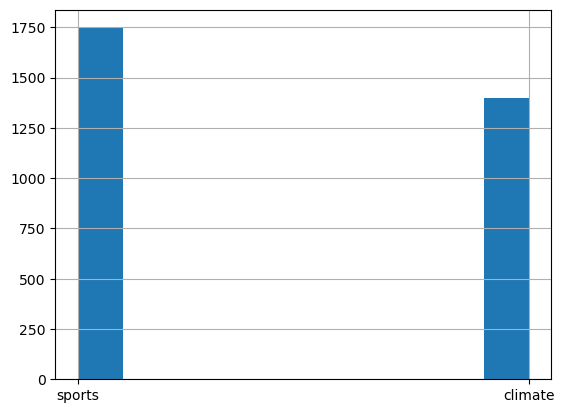

In [5]:
# q1 histogram (c)
data['root_label'].hist()

### Interpret Plots: 
#### Most text in this dataset have under 10000 alphabetic or numeric characters, and only few samples have 20000, 30000, or more alphabetic or numeric characters. As the leaf_topic histogram shown, text about 9 different topics are collected so that each topic has the same frequency. As we can see from the root_topic histogram, text in the dataset are separated into two different root labels: sports and climate, and the dataset focus more on sports.

### 1 Split into train and test data

In [6]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data[["full_text","root_label", "leaf_label"]], test_size=0.2)

In [8]:
print(train.shape, test.shape)

(2520, 3) (630, 3)


# Question 2:
#### There are 2520 samples in training data and 630 samples in testing data. 

### 2 Feature Extraction

In [9]:
import re
def clean(text):
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        texter = re.sub(r"<br />", " ", text)
        texter = re.sub(r"&quot;", "\"",texter)
        texter = re.sub('&#39;', "\"", texter)
        texter = re.sub('\n', " ", texter)
        texter = re.sub(' u '," you ", texter)
        texter = re.sub('`',"", texter)
        texter = re.sub(' +', ' ', texter)
        texter = re.sub(r"(!)\1+", r"!", texter)
        texter = re.sub(r"(\?)\1+", r"?", texter)
        texter = re.sub('&amp;', 'and', texter)
        texter = re.sub('\r', ' ',texter)
        clean = re.compile('<.*?>')
        texter = texter.encode('ascii', 'ignore').decode('ascii')
        texter = re.sub(clean, '', texter)
        if texter == "":
            texter = ""
        return texter

In [10]:
train_text = train.full_text
test_text = test.full_text

In [11]:
df_train = []
df_test = []
for x in train_text:
    ff = clean(x)
    df_train.append(ff)

for x in test_text:
    ff = clean(x)
    df_test.append(ff)

In [12]:
from nltk import pos_tag

wnl = nltk.wordnet.WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')


def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
def lemmatize_sent_demo(text): 
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(nltk.word_tokenize(text))]
def lemmatize_sent(list_word): 
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 8] nodename nor servname provided, or not
[nltk_data]     known>


In [13]:
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
#nltk.download('stopwords' )
stop_words_en = stopwords.words('english')

print("# of stop_words_skt:\t\t %s" % len(stop_words_skt))
print("# of stop_words_en:\t\t %s" % len(stop_words_en))
from string import punctuation
print("# of punctuation:\t\t %s" % len(punctuation))
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
print("# of combined_stopwords:\t %s" % len(combined_stopwords))

# of stop_words_skt:		 318
# of stop_words_en:		 179
# of punctuation:		 32
# of combined_stopwords:	 410


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
analyzer = CountVectorizer().build_analyzer()
def stem_rmv_punc(doc):
    return [word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit()]

In [15]:
from sklearn.pipeline import Pipeline
vectorizer = CountVectorizer(min_df=3,analyzer=stem_rmv_punc)
pipe = Pipeline([('count', vectorizer),('tfid', TfidfTransformer())])

# Question 3
#### pros: lemmatization is more accurate and better quality. 
#### cons: lemmatization takes longer and harder to implement. 
#### As above states, lemmatization has larger dictionary size than stemming. 
#### min_df remove the words that appear too frequency. So, as min_df increases, TF-IDF matrix decreases. 
#### Lemmatization goes first. Remove stopwords, punctuations, and numbers after lemmatization because stopwords, punctuations, and numbers will affect lemmatization and influence the output. 

In [16]:
# shape of the TF-IDF-processed train matrices:
df_train_transform = pipe.fit_transform(df_train)
print(df_train_transform.shape)

(2520, 13715)


In [17]:
# shape of the TF-IDF-processed test matrices:
df_test_transform = pipe.transform(df_test)
print(df_test_transform.shape)

(630, 13715)


### 3 Dimensionality Reduction

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

In [19]:
Ratio = []
for x in [1, 10, 50, 100, 200, 500, 1000, 2000]:
    svd = TruncatedSVD(n_components=x, n_iter=7, random_state=42)
    Reduced_train_it = svd.fit(df_train_transform)
    Ratio.append(Reduced_train_it.explained_variance_ratio_.sum())
print(Ratio)

[0.006265247957095017, 0.15565720322040077, 0.31537059538483647, 0.40478978193176157, 0.5166887933258043, 0.7103445122032148, 0.8814187974243514, 0.9999893739634246]


In [20]:
k = [1,10,50,100,200,500,1000,2000]

# Question 4

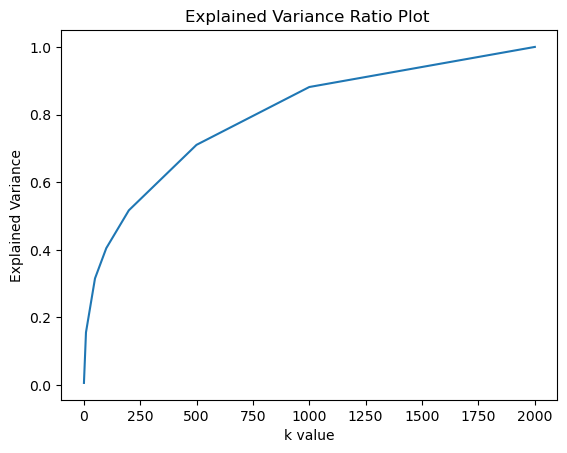

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(k, Ratio)
plt.title("Explained Variance Ratio Plot ")
plt.xlabel('k value') 
plt.ylabel('Explained Variance') 
plt.show()

### As k increase, explained variance ratio increases. The concavity in the plot suggests that k=50 should be the best k value which with simplest complexity and high variance explained. 

In [22]:
from sklearn.decomposition import NMF
NMF_1 = NMF(n_components=50, init='random', random_state=42)
W = NMF_1.fit_transform(df_train_transform)
H = NMF_1.components_

/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [23]:
print("residual MSE error when use NMF is", np.linalg.norm(df_train_transform-np.dot(W,H))**2)

residual MSE error when use NMF is 1697.8966418551884


In [24]:
svd_50 = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
U, sigma, V_t = randomized_svd(df_train_transform, n_components=50, random_state=42)

In [25]:
s=np.diag(sigma)

In [26]:
Reduced_train = U.dot(s).dot(V_t)
print("residual MSE error when use LSI is", np.linalg.norm(df_train_transform-Reduced_train)**2)

residual MSE error when use LSI is 1669.3038263016601


### Residual MSE error in NMF is larger. NMF's bases and weights constrains to be positive, so only additive combination is allowed. And it construct sparse bases and weights. LSI usually considers only essential components of term-by-document matrix, filters out noise. 

### 4 Classification Algorithms

In [27]:
train_LSI50 = svd_50.fit_transform(df_train_transform)
test_LSI50 = svd_50.transform(df_test_transform)

### Question 5

#### - Train SVM model with γ = 1000 (hard margin) and γ = 0.0001 (soft margin)

In [28]:
from sklearn import svm

clf_hard = svm.SVC(kernel='linear', C = 1000, probability=True)
clf_hard.fit(train_LSI50, train.root_label)
hard_predicted = clf_hard.predict(test_LSI50)

In [29]:
clf_soft = svm.SVC(kernel='linear', C = 0.0001, probability=True)
clf_soft.fit(train_LSI50, train.root_label)
soft_predicted = clf_soft.predict(test_LSI50)

#### - Train SVM model with γ = 100000

In [30]:
clf_100000 = svm.SVC(kernel='linear', C = 100000, probability=True)
clf_100000.fit(train_LSI50, train.root_label)
clf_100000_predicted = clf_100000.predict(test_LSI50)

#### – Plot the ROC curve

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(model, train_data, train_label, test_data, test_label):
    model.fit(train_data, train_label)

    prob_score = model.predict_proba(test_data)

    fpr, tpr, _ = roc_curve(test_label, prob_score[:,1], pos_label="sports")

    plot_roc(fpr, tpr)
    return model

SVC(C=1000, kernel='linear', probability=True)

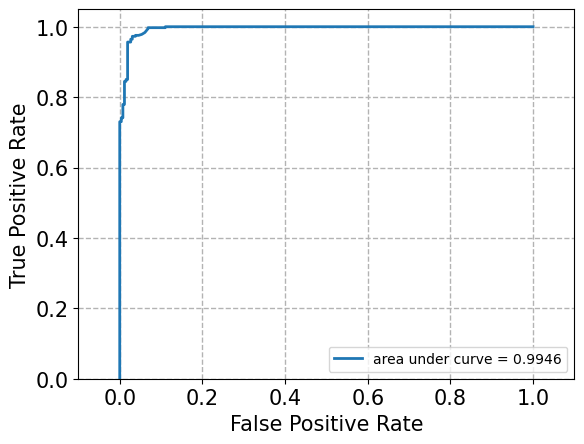

In [32]:
fit_predict_and_plot_roc(clf_hard, train_LSI50, train.root_label, test_LSI50, test.root_label)

SVC(C=0.0001, kernel='linear', probability=True)

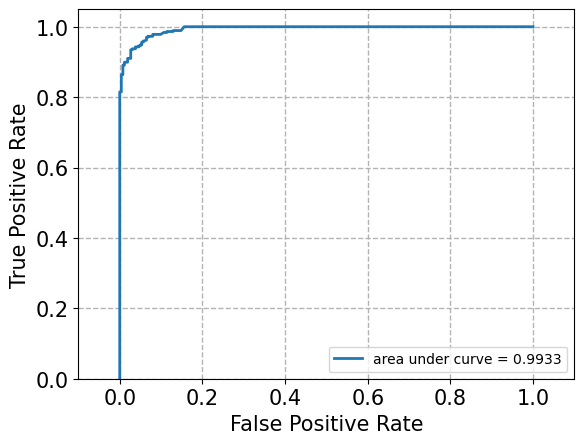

In [33]:
fit_predict_and_plot_roc(clf_soft, train_LSI50, train.root_label, test_LSI50, test.root_label)

SVC(C=100000, kernel='linear', probability=True)

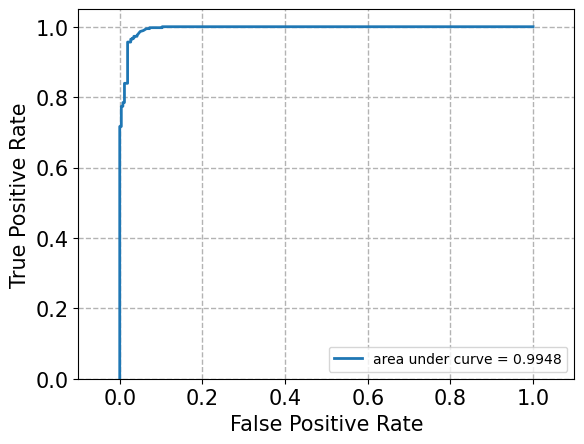

In [34]:
fit_predict_and_plot_roc(clf_100000, train_LSI50, train.root_label, test_LSI50, test.root_label)

#### - Report the confusion matrix

In [35]:
from sklearn import metrics
confusion_matrix_hard = metrics.confusion_matrix(test.root_label, hard_predicted,
                                                labels=clf_hard.classes_)
print("confusion matrix of hard margin\n",
      confusion_matrix_hard)

confusion matrix of hard margin
 [[258   5]
 [ 18 349]]


In [36]:
# Plot confusion matrix
import matplotlib.pyplot as plot
from sklearn.metrics import ConfusionMatrixDisplay
def cm_plot_2(cm,model,title,x):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=x)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    disp.ax_.set_title(title)

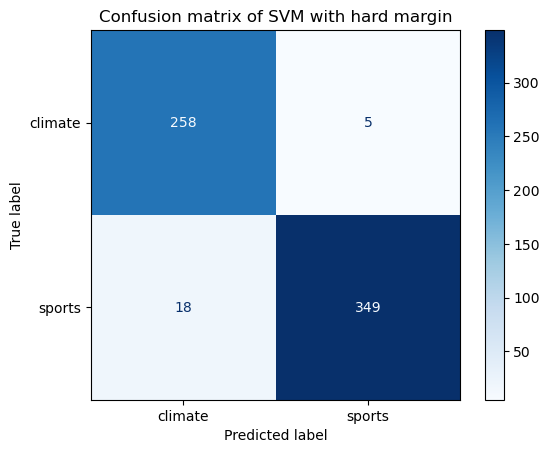

In [37]:
cm_plot_2(confusion_matrix_hard, clf_hard, title="Confusion matrix of SVM with hard margin", x=clf_hard.classes_)

In [38]:
confusion_matrix_soft = metrics.confusion_matrix(test.root_label, soft_predicted)
print("confusion matrix of hard margin\n",
      confusion_matrix_soft)

confusion matrix of hard margin
 [[  0 263]
 [  0 367]]


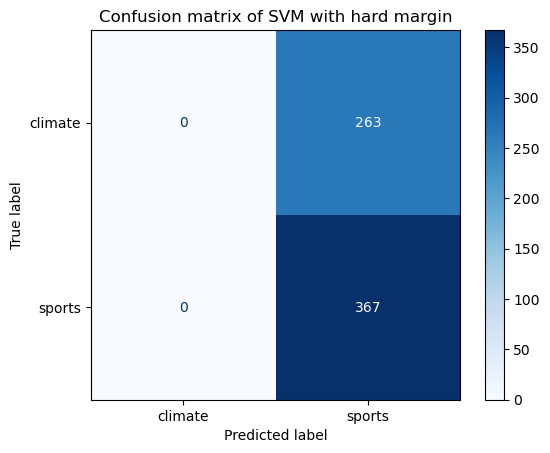

In [39]:
cm_plot_2(confusion_matrix_soft, clf_soft, title="Confusion matrix of SVM with hard margin", x=clf_soft.classes_)

In [40]:
confusion_matrix_100000 = metrics.confusion_matrix(test.root_label, clf_100000_predicted)
print("confusion matrix of γ = 100000\n",
      confusion_matrix_100000)

confusion matrix of γ = 100000
 [[258   5]
 [ 17 350]]


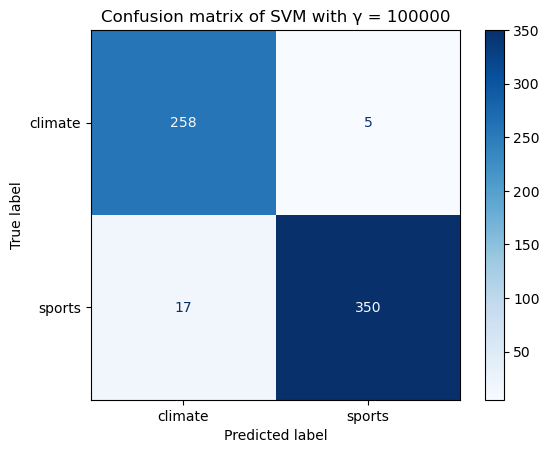

In [41]:
cm_plot_2(confusion_matrix_100000, clf_100000, 
          title="Confusion matrix of SVM with γ = 100000", x=clf_100000.classes_)

#### - Accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set

In [42]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
def score_table_root(actual_y, predicted_y, Name, average="binary", pos_label="sports"):
    dict={'Score type':['Accuracy','Recall','Precision','F1'],
          Name:[accuracy_score(actual_y,predicted_y),
                   recall_score(actual_y,predicted_y,average=average,pos_label=pos_label),
                   precision_score(actual_y,predicted_y,average=average,pos_label=pos_label),
                   f1_score(actual_y,predicted_y,pos_label=pos_label)]}
    report=pd.DataFrame(dict)
    return(report)

In [43]:
score_table_root(test.root_label, hard_predicted, Name='Hard Margin')

,Score type,Hard Margin
0,Accuracy,0.963492
1,Recall,0.950954
2,Precision,0.985876
3,F1,0.968100


In [44]:
score_table_root(test.root_label, soft_predicted, Name='Soft Margin')

,Score type,Soft Margin
0,Accuracy,0.582540
1,Recall,1.000000
2,Precision,0.582540
3,F1,0.736209


In [45]:
score_table_root(test.root_label, clf_100000_predicted, Name='γ = 100000')

,Score type,γ = 100000
0,Accuracy,0.965079
1,Recall,0.953678
2,Precision,0.985915
3,F1,0.969529


### As γ increases, accuracy of SVM model increases. When γ = 100000, it has highest accuracy, but it's not big difference between γ = 1000 (hard margin) and γ = 100000. However, it increases complexity of model and time spent on computing. 

### Soft margin SVM has very low score and predict all "Climates" value to "Sports". And here we only have two category to classify which means SVM model with soft margin actually does not predict anything. SVM with soft margin easily predict "sports" to "climate". It caused by γ is too small and brought the margin is too not big enough. 

#### - Cross-Validation

In [46]:
from sklearn.model_selection import GridSearchCV
params = {'C':[0.001,0.01,0.1,1,10,100,1000]}
search = GridSearchCV(svm.SVC(kernel='linear', probability=True),params, n_jobs=10,cv=5,scoring='accuracy')
search.fit(train_LSI50,train.root_label)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True), n_jobs=10,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy')

In [47]:
search.best_params_

{'C': 100}

### the best value of the parameter γ is 100

In [48]:
clf_best = svm.SVC(kernel='linear', C = 100, probability=True)
clf_best.fit(train_LSI50, train.root_label)
best_predicted = clf_best.predict(test_LSI50)

SVC(C=100, kernel='linear', probability=True)

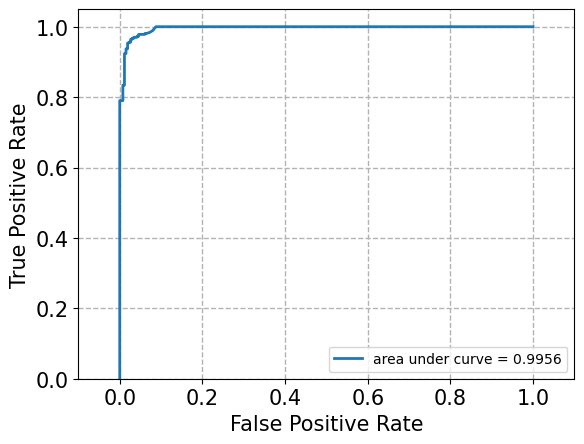

In [49]:
fit_predict_and_plot_roc(clf_best, train_LSI50, train.root_label, test_LSI50, test.root_label)

In [50]:
confusion_matrix_best = metrics.confusion_matrix(test.root_label, best_predicted)
print("confusion matrix of best margin (γ =100)\n",
      confusion_matrix_best)

confusion matrix of best margin (γ =100)
 [[258   5]
 [ 17 350]]


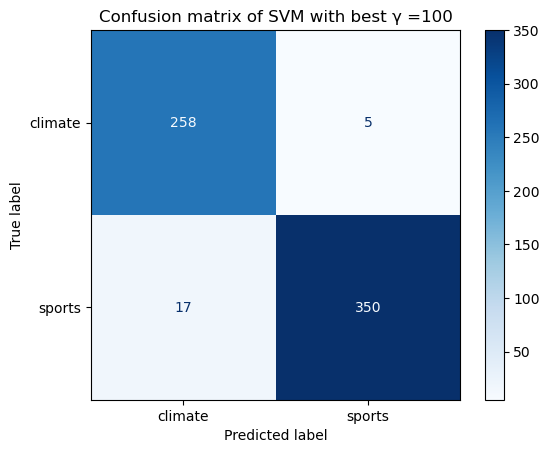

In [51]:
cm_plot_2(confusion_matrix_best, clf_best, title="Confusion matrix of SVM with best γ =100", x=clf_best.classes_)

In [52]:
score_table_root(test.root_label, best_predicted, Name='SVM with best γ =100')

,Score type,SVM with best γ =100
0,Accuracy,0.965079
1,Recall,0.953678
2,Precision,0.985915
3,F1,0.969529


### Question 6 Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
Logistic_r = LogisticRegression(C=10**11,solver='liblinear',random_state=42)
Logistic_r.fit(train_LSI50,train.root_label)

LogisticRegression(C=100000000000, random_state=42, solver='liblinear')

In [54]:
Lr_no_predict = Logistic_r.predict(test_LSI50)

In [55]:
confusion_matrix_no_reg = metrics.confusion_matrix(test.root_label, Lr_no_predict)
print("No regulerization")
print(confusion_matrix_best)

No regulerization
[[258   5]
 [ 17 350]]


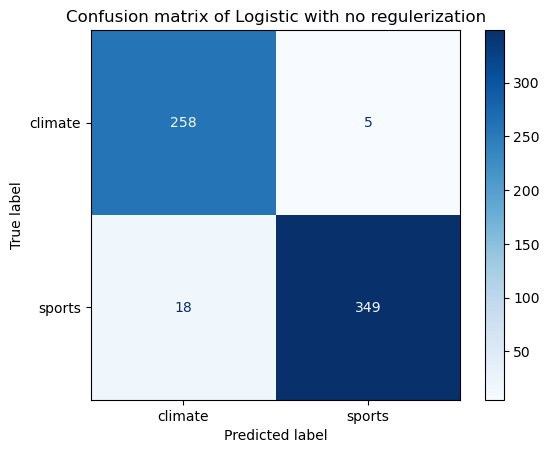

In [56]:
cm_plot_2(confusion_matrix_no_reg, Logistic_r, title="Confusion matrix of Logistic with no regulerization",
         x=Logistic_r.classes_)

LogisticRegression(C=100000000000, random_state=42, solver='liblinear')

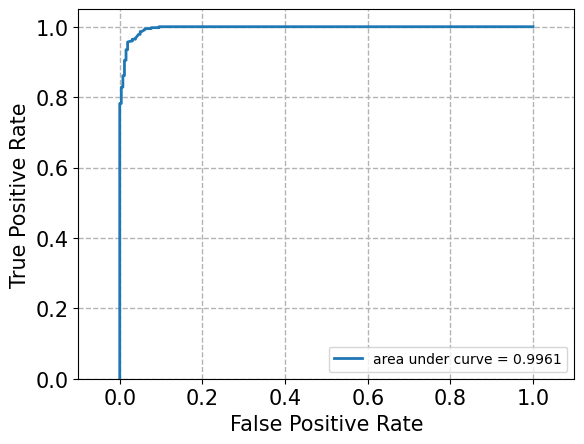

In [57]:
fit_predict_and_plot_roc(Logistic_r, train_LSI50, train.root_label, test_LSI50, test.root_label)

In [58]:
score_table_root(test.root_label, Lr_no_predict, Name='Logistic No Regularization')

,Score type,Logistic No Regularization
0,Accuracy,0.963492
1,Recall,0.950954
2,Precision,0.985876
3,F1,0.968100


In [59]:
params = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
search_L1_lr = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear',random_state=42),
                            params, n_jobs=10, cv=5,scoring='accuracy')
search_L1_lr.fit(train_LSI50,train.root_label)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='liblinear'),
             n_jobs=10,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             scoring='accuracy')

In [60]:
params = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
search_L2_lr = GridSearchCV(LogisticRegression(penalty='l2',solver='liblinear',random_state=42),
                            params, n_jobs=10, cv=5,scoring='accuracy')
search_L2_lr.fit(train_LSI50,train.root_label)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             n_jobs=10,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             scoring='accuracy')

In [61]:
print(search_L1_lr.best_params_)
print(search_L2_lr.best_params_)

{'C': 100}
{'C': 1000}


### the optimal regularization strength for logistic regression with L1 regularization is 100
### the optimal regularization strength for logistic regression with L2 regularization is 1000

In [62]:
Logistic_l1 = LogisticRegression(C=100,solver='liblinear',random_state=42,penalty='l1')
Logistic_l1.fit(train_LSI50,train.root_label)
Lr_l1_predict = Logistic_l1.predict(test_LSI50)
Logistic_l2 = LogisticRegression(C=1000,solver='liblinear',random_state=42,penalty='l2')
Logistic_l2.fit(train_LSI50,train.root_label)
Lr_l2_predict = Logistic_l2.predict(test_LSI50)

In [63]:
Logistic_data={'Score type':['Accuracy','Recall','Precision','F1'],
          'No Regularization':[accuracy_score(test.root_label,Lr_no_predict),
                   recall_score(test.root_label,Lr_no_predict,
                                                 average='binary',pos_label="sports"),
                   precision_score(test.root_label,Lr_no_predict,
                                                       average='binary',pos_label="sports"),
                   f1_score(test.root_label,Lr_no_predict,pos_label="sports")],
         'L1 Regularization':[accuracy_score(test.root_label,Lr_l1_predict),
                   recall_score(test.root_label,Lr_l1_predict,
                                                 average='binary',pos_label="sports"),
                   precision_score(test.root_label,Lr_l1_predict,
                                                       average='binary',pos_label="sports"),
                   f1_score(test.root_label,Lr_l1_predict,pos_label="sports")],
         'L2 Regularization':[accuracy_score(test.root_label,Lr_l2_predict),
                   recall_score(test.root_label,Lr_l2_predict,
                                                 average='binary',pos_label="sports"),
                   precision_score(test.root_label,Lr_l2_predict,
                                                       average='binary',pos_label="sports"),
                   f1_score(test.root_label,Lr_l2_predict,pos_label="sports")]}

Logistic_report=pd.DataFrame(Logistic_data)

Logistic_report

,Score type,No Regularization,L1 Regularization,L2 Regularization
0,Accuracy,0.963492,0.963492,0.965079
1,Recall,0.950954,0.950954,0.953678
2,Precision,0.985876,0.985876,0.985915
3,F1,0.968100,0.968100,0.969529


### Regularization does NOT improve the performance on the seeing data set. But adding Regularization L2 will have better generalization performance on unseeing data, test data set. 
### As value of penalty increases, the coefficient shink. 
### L1 is lasso regression, adds the “absolute value of magnitude” of the coefficient as a penalty term to the loss function. L2 Regularization, also called a ridge regression, adds the “squared magnitude” of the coefficient as the penalty term to the loss function.

### SVM tries to make a decision boundary in such a way that the separation between the two classes is as wide as possible.
### Logistic Regression has different decision boundaries with different weights that are near the optimal point.
### SVM works well with unstructured and semi-structured data like text and images while logistic regression works with already identified independent variables. SVM is based on geometrical properties of the data while logistic regression is based on statistical approaches.
### It's more statistically significant for logistic regression because it tries to maximize the conditional likelihood of training date. 

### Question 7 Na ̈ıve Bayes Model

In [64]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
NB_predicted = gnb.fit(train_LSI50, train.root_label).predict(test_LSI50)

In [65]:
confusion_matrix_NB = metrics.confusion_matrix(test.root_label, NB_predicted)
print("confusion matrix of Naive Bayes Model\n",
      confusion_matrix_NB)

confusion matrix of Naive Bayes Model
 [[259   4]
 [ 37 330]]


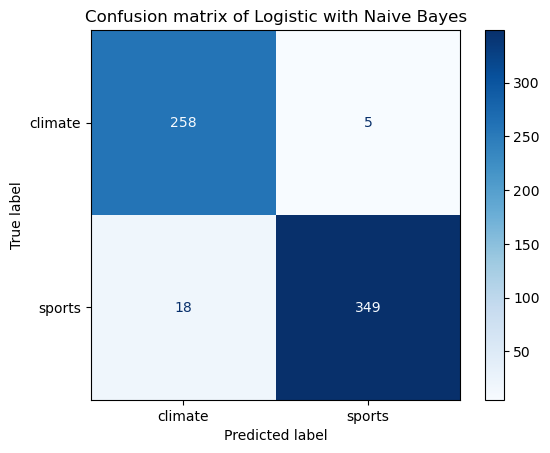

In [66]:
cm_plot_2(confusion_matrix_no_reg, Logistic_r, title="Confusion matrix of Logistic with Naive Bayes",
         x=Logistic_r.classes_)

GaussianNB()

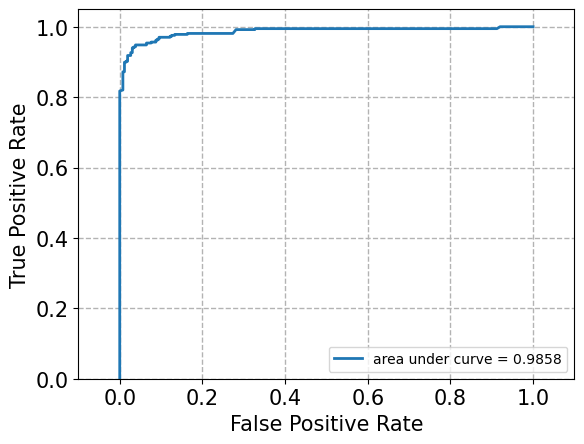

In [67]:
fit_predict_and_plot_roc(gnb, train_LSI50, train.root_label, test_LSI50, test.root_label)

In [68]:
score_table_root(test.root_label, NB_predicted, Name='Naive Bayes')

,Score type,Naive Bayes
0,Accuracy,0.934921
1,Recall,0.899183
2,Precision,0.988024
3,F1,0.941512


# Question 8

In [69]:
analyzer = CountVectorizer().build_analyzer()
df_trainLe=[]
df_testLe=[]
for x in range(len(df_train)):
    lis = lemmatize_sent(analyzer(df_train[x]))
    lis = [i for i in lis if i not in combined_stopwords and not i.isdigit()]
    df_trainLe.append(" ".join(lis))

for x in range(len(df_test)):
    lis = lemmatize_sent(analyzer(df_test[x]))
    lis = [i for i in lis if i not in combined_stopwords and not i.isdigit()]
    df_testLe.append(" ".join(lis))

In [70]:
cachedir = mkdtemp()
pipe_com = Pipeline(steps=[
                       ('vect', CountVectorizer(stop_words='english')),
                       ('Tfid', TfidfTransformer()),
                       ('Reduction', None), 
                       ('classify', None)], memory=cachedir)
param_grid = {
    'vect__min_df':[3,5],
    'Reduction': [TruncatedSVD(n_components=5, random_state=42),
                  TruncatedSVD(n_components=30, random_state=42),
                 TruncatedSVD(n_components=80, random_state=42),
                  NMF(n_components=5, init='random', random_state=42),
                  NMF(n_components=30, init='random', random_state=42),
                  NMF(n_components=80, init='random', random_state=42)
                 ],
    'classify': [svm.SVC(kernel='linear', C = 100, probability=True),
                 LogisticRegression(penalty='l1',C=1000,solver='liblinear',random_state=42),
                 LogisticRegression(penalty='l2',C=100,solver='liblinear',random_state=42),
                 GaussianNB()]
    }

In [71]:
search_com = GridSearchCV(pipe_com,cv=5,param_grid=param_grid,scoring='accuracy',n_jobs=-1)

In [72]:
search_com.fit(df_trainLe,train.root_label)

/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve 

GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/tmp82wed18x',
                                steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('Tfid', TfidfTransformer()),
                                       ('Reduction', None),
                                       ('classify', None)]),
             n_jobs=-1,
             param_grid={'Reduction': [TruncatedSVD(n_components=5,
                                                    random_state=42),
                                       TruncatedSVD(n_components=30,
                                                    random_state=...
                                       NMF(init='random', n_components=30,
                                           random_state=42),
                                       NMF(init='random', n_components=80,
                                           random_state=42)],
                         'classify': [SVC(C=100, kernel='linear',
                                          probability=True),
                                      LogisticRegression(C=1000, penalty='l1',
                                                         random_state=42,
                                                         solver='liblinear'),
                                      LogisticRegression(C=100, random_state=42,
                                                         solver='liblinear'),
                                      GaussianNB()],
                         'vect__min_df': [3, 5]},
             scoring='accuracy')

In [73]:
search_com.best_params_

{'Reduction': TruncatedSVD(n_components=80, random_state=42),
 'classify': SVC(C=100, kernel='linear', probability=True),
 'vect__min_df': 5}

In [74]:
search_com_stm = GridSearchCV(pipe_com,cv=5,param_grid=param_grid,scoring='accuracy',n_jobs=-1)

In [75]:
df_trainST=[]
df_testST=[]
for x in range(len(df_train)):
    lis = analyzer(df_train[x])
    lis = [stemmer.stem(w) for w in lis]
    df_trainST.append(" ".join(lis))

for x in range(len(df_test)):
    lis = analyzer(df_train[x])
    lis = [stemmer.stem(w) for w in lis]
    df_testST.append(" ".join(lis))

In [76]:
search_com_stm.fit(df_trainST,train.root_label)

/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve 

GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/tmp82wed18x',
                                steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('Tfid', TfidfTransformer()),
                                       ('Reduction', None),
                                       ('classify', None)]),
             n_jobs=-1,
             param_grid={'Reduction': [TruncatedSVD(n_components=5,
                                                    random_state=42),
                                       TruncatedSVD(n_components=30,
                                                    random_state=...
                                       NMF(init='random', n_components=30,
                                           random_state=42),
                                       NMF(init='random', n_components=80,
                                           random_state=42)],
                         'classify': [SVC(C=100, kernel='linear',
                                          probability=True),
                                      LogisticRegression(C=1000, penalty='l1',
                                                         random_state=42,
                                                         solver='liblinear'),
                                      LogisticRegression(C=100, random_state=42,
                                                         solver='liblinear'),
                                      GaussianNB()],
                         'vect__min_df': [3, 5]},
             scoring='accuracy')

In [77]:
search_com_stm.best_params_

{'Reduction': TruncatedSVD(n_components=80, random_state=42),
 'classify': LogisticRegression(C=100, random_state=42, solver='liblinear'),
 'vect__min_df': 5}

In [78]:
dff = pd.DataFrame(search_com_stm.cv_results_)
dff["Featrue_E"]="Stemmer"

In [79]:
drr = pd.DataFrame(search_com.cv_results_)
drr["Featrue_E"]="Limai"

In [80]:
comb_df=pd.concat([dff,drr])

In [81]:
comb_df.sort_values(by='mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Reduction,param_classify,param_vect__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,Featrue_E
17,0.703520,0.021716,0.070422,0.007381,"TruncatedSVD(n_components=80, random_state=42)","SVC(C=100, kernel='linear', probability=True)",5,"{'Reduction': TruncatedSVD(n_components=80, ra...",0.954365,0.980159,0.966270,0.952381,0.952381,0.961111,0.010838,1,Limai
19,0.233962,0.057772,0.063236,0.006007,"TruncatedSVD(n_components=80, random_state=42)","LogisticRegression(C=1000, penalty='l1', rando...",5,"{'Reduction': TruncatedSVD(n_components=80, ra...",0.962302,0.976190,0.964286,0.950397,0.952381,0.961111,0.009272,1,Limai
21,0.117300,0.003927,0.067256,0.004090,"TruncatedSVD(n_components=80, random_state=42)","LogisticRegression(C=100, random_state=42, sol...",5,"{'Reduction': TruncatedSVD(n_components=80, ra...",0.956349,0.976190,0.966270,0.948413,0.954365,0.960317,0.009801,3,Limai
41,19.686157,3.946527,0.164434,0.016269,"NMF(init='random', n_components=80, random_sta...","SVC(C=100, kernel='linear', probability=True)",5,"{'Reduction': NMF(init='random', n_components=...",0.958333,0.966270,0.960317,0.950397,0.962302,0.959524,0.005264,4,Limai
18,0.374607,0.338902,0.067937,0.006923,"TruncatedSVD(n_components=80, random_state=42)","LogisticRegression(C=1000, penalty='l1', rando...",3,"{'Reduction': TruncatedSVD(n_components=80, ra...",0.958333,0.976190,0.962302,0.950397,0.946429,0.958730,0.010378,5,Limai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,0.085710,0.001857,0.084278,0.006713,"TruncatedSVD(n_components=5, random_state=42)",GaussianNB(),3,"{'Reduction': TruncatedSVD(n_components=5, ran...",0.900794,0.918651,0.928571,0.873016,0.892857,0.902778,0.019521,45,Stemmer
28,0.102374,0.010778,0.105610,0.011836,"NMF(init='random', n_components=5, random_stat...","LogisticRegression(C=100, random_state=42, sol...",3,"{'Reduction': NMF(init='random', n_components=...",0.918651,0.789683,0.940476,0.926587,0.914683,0.898016,0.054880,46,Stemmer
24,0.383076,0.051378,0.115891,0.018734,"NMF(init='random', n_components=5, random_stat...","SVC(C=100, kernel='linear', probability=True)",3,"{'Reduction': NMF(init='random', n_components=...",0.918651,0.775794,0.936508,0.924603,0.906746,0.892460,0.059118,47,Stemmer
6,0.088394,0.004041,0.063762,0.009901,"TruncatedSVD(n_components=5, random_state=42)",GaussianNB(),3,"{'Reduction': TruncatedSVD(n_components=5, ran...",0.906746,0.859127,0.922619,0.867063,0.904762,0.892063,0.024578,48,Limai


In [82]:
pipe_top1 = Pipeline(steps=[
                       ('vect', CountVectorizer(min_df=5,stop_words='english')),
                       ('Tfid', TfidfTransformer()),
                       ('Reduction', TruncatedSVD(n_components=80, random_state=42)), 
                       ('classify', svm.SVC(kernel='linear', C = 100, probability=True))])
pipe_top1.fit(df_trainLe,train.root_label)

Pipeline(steps=[('vect', CountVectorizer(min_df=5, stop_words='english')),
                ('Tfid', TfidfTransformer()),
                ('Reduction', TruncatedSVD(n_components=80, random_state=42)),
                ('classify', SVC(C=100, kernel='linear', probability=True))])

In [83]:
pipe_top2 = Pipeline(steps=[
                       ('vect', CountVectorizer(min_df=5,stop_words='english')),
                       ('Tfid', TfidfTransformer()),
                       ('Reduction', TruncatedSVD(n_components=80, random_state=42)), 
                       ('classify', LogisticRegression(penalty='l1',C=1000,solver='liblinear',random_state=42))])
pipe_top2.fit(df_trainLe,train.root_label)

Pipeline(steps=[('vect', CountVectorizer(min_df=5, stop_words='english')),
                ('Tfid', TfidfTransformer()),
                ('Reduction', TruncatedSVD(n_components=80, random_state=42)),
                ('classify',
                 LogisticRegression(C=1000, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [84]:
pipe_top3 = Pipeline(steps=[
                       ('vect', CountVectorizer(min_df=5,stop_words='english')),
                       ('Tfid', TfidfTransformer()),
                       ('Reduction', TruncatedSVD(n_components=80, random_state=42)), 
                       ('classify', LogisticRegression(penalty='l2',C=100,solver='liblinear',random_state=42))])
pipe_top3.fit(df_trainLe,train.root_label)

Pipeline(steps=[('vect', CountVectorizer(min_df=5, stop_words='english')),
                ('Tfid', TfidfTransformer()),
                ('Reduction', TruncatedSVD(n_components=80, random_state=42)),
                ('classify',
                 LogisticRegression(C=100, random_state=42,
                                    solver='liblinear'))])

In [85]:
pipe_top4 = Pipeline(steps=[
                       ('vect', CountVectorizer(min_df=5,stop_words='english')),
                       ('Tfid', TfidfTransformer()),
                       ('Reduction', NMF(init='random', n_components=80, random_state=42)), 
                       ('classify', svm.SVC(kernel='linear', C = 100, probability=True))])
pipe_top4.fit(df_trainLe,train.root_label)

/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Pipeline(steps=[('vect', CountVectorizer(min_df=5, stop_words='english')),
                ('Tfid', TfidfTransformer()),
                ('Reduction',
                 NMF(init='random', n_components=80, random_state=42)),
                ('classify', SVC(C=100, kernel='linear', probability=True))])

In [86]:
pipe_top5 = Pipeline(steps=[
                       ('vect', CountVectorizer(min_df=3,stop_words='english')),
                       ('Tfid', TfidfTransformer()),
                       ('Reduction', TruncatedSVD(n_components=80, random_state=42)), 
                       ('classify', LogisticRegression(penalty='l1',C=1000,solver='liblinear',random_state=42))])
pipe_top5.fit(df_trainLe,train.root_label)

Pipeline(steps=[('vect', CountVectorizer(min_df=3, stop_words='english')),
                ('Tfid', TfidfTransformer()),
                ('Reduction', TruncatedSVD(n_components=80, random_state=42)),
                ('classify',
                 LogisticRegression(C=1000, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [87]:
def score_table_root(actual_y, predicted_y, Name, average="binary", pos_label="sports"):
    dict={'Score type':['Accuracy','Recall','Precision','F1'],
          Name:[accuracy_score(actual_y,predicted_y),
                   recall_score(actual_y,predicted_y,average=average,pos_label=pos_label),
                   precision_score(actual_y,predicted_y,average=average,pos_label=pos_label),
                   f1_score(actual_y,predicted_y,pos_label=pos_label)]}
    report=pd.DataFrame(dict)
    return(report)

In [88]:
score_table_root(test.root_label, pipe_top1.predict(df_testLe), Name="top 1 pipeline combination")

,Score type,top 1 pipeline combination
0,Accuracy,0.965079
1,Recall,0.959128
2,Precision,0.980501
3,F1,0.969697


In [89]:
score_table_root(test.root_label, pipe_top2.predict(df_testLe), Name="top 2 pipeline combination")

,Score type,top 2 pipeline combination
0,Accuracy,0.969841
1,Recall,0.961853
2,Precision,0.986034
3,F1,0.973793


In [90]:
score_table_root(test.root_label, pipe_top3.predict(df_testLe), Name="top 3 pipeline combination")

,Score type,top 3 pipeline combination
0,Accuracy,0.965079
1,Recall,0.956403
2,Precision,0.983193
3,F1,0.969613


In [91]:
score_table_root(test.root_label, pipe_top4.predict(df_testLe), Name="top 4 pipeline combination")

,Score type,top 4 pipeline combination
0,Accuracy,0.960317
1,Recall,0.948229
2,Precision,0.983051
3,F1,0.965326


In [92]:
score_table_root(test.root_label, pipe_top5.predict(df_testLe), Name="top 5 pipeline combination")

,Score type,top 5 pipeline combination
0,Accuracy,0.968254
1,Recall,0.961853
2,Precision,0.983287
3,F1,0.972452


In [93]:
print("Accyracy Score of Top 1:",accuracy_score(test.root_label, pipe_top1.predict(df_testLe)))
print("Accyracy Score of Top 2:",accuracy_score(test.root_label, pipe_top2.predict(df_testLe)))
print("Accyracy Score of Top 3:",accuracy_score(test.root_label, pipe_top3.predict(df_testLe)))
print("Accyracy Score of Top 4:",accuracy_score(test.root_label, pipe_top4.predict(df_testLe)))
print("Accyracy Score of Top 5:",accuracy_score(test.root_label, pipe_top5.predict(df_testLe)))

Accyracy Score of Top 1: 0.9650793650793651
Accyracy Score of Top 2: 0.9698412698412698
Accyracy Score of Top 3: 0.9650793650793651
Accyracy Score of Top 4: 0.9603174603174603
Accyracy Score of Top 5: 0.9682539682539683


# Question 9 Multiclass Classification

### Naive Bayes classification

In [94]:
def score_table_leaf(actual_y, predicted_y, Name, average="weighted"):
    dict={'Score type':['Accuracy','Recall','Precision','F1'],
          Name:[accuracy_score(actual_y,predicted_y),
                   recall_score(actual_y,predicted_y,average=average),
                   precision_score(actual_y,predicted_y,average=average),
                   f1_score(actual_y,predicted_y,average=average)]}
    report=pd.DataFrame(dict)
    return(report)

In [95]:
gnb = GaussianNB()
y_pred_NB_multi = gnb.fit(train_LSI50,train.leaf_label).predict(test_LSI50)
score_table_leaf(test.leaf_label, y_pred_NB_multi, Name='Naive Bayes Multi')

,Score type,Naive Bayes Multi
0,Accuracy,0.742857
1,Recall,0.742857
2,Precision,0.740440
3,F1,0.735078


In [96]:
map_row_to_class = {0:"chess", 1:"cricket", 2:"hockey", 3:"soccer",
                    4:"football", 5:"%22forest%20fire%22", 6:"flood", 7:"earthquake",
                    8:"drought"}
my_list = list(map_row_to_class.values())

In [97]:
confusion_matrix_NB_multi = metrics.confusion_matrix(test.leaf_label,y_pred_NB_multi,
                                                    labels = my_list)
print("confusion matrix of Naive Bayes Model\nmulticlassification\n",
      confusion_matrix_NB_multi)

confusion matrix of Naive Bayes Model
multiclassification
 [[61  0  1  1  0  1  0  7  0]
 [ 3 73  1  0  0  1  0  3  0]
 [ 1  0 77  1  0  2  0  3  2]
 [ 4  0  6 20 36  0  0  2  0]
 [ 3  0  8 19 28  0  0  3  0]
 [ 3  0  0  0  0 41  8  6  4]
 [ 0  0  1  0  0  3 64  3  3]
 [ 2  0  1  0  0  0  0 54  2]
 [ 0  0  3  0  0  6  5  4 50]]


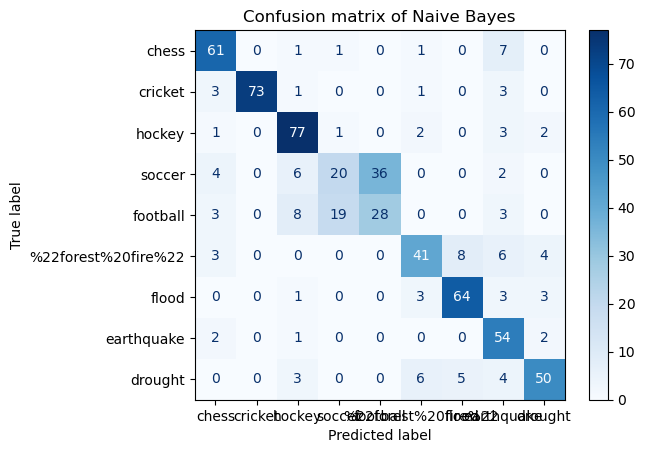

In [98]:
cm_plot_2(confusion_matrix_NB_multi, gnb, title="Confusion matrix of Naive Bayes", x=my_list)

### SVM with One VS One 

In [99]:
from sklearn.multiclass import OneVsOneClassifier
clf_multi = OneVsOneClassifier(svm.SVC(kernel='linear', random_state=42),n_jobs=-1)
clf_multi_predicted = clf_multi.fit(train_LSI50, train.leaf_label).predict(test_LSI50)

In [100]:
score_table_leaf(test.leaf_label, clf_multi_predicted, Name='SVM with One VS One')

,Score type,SVM with One VS One
0,Accuracy,0.798413
1,Recall,0.798413
2,Precision,0.826654
3,F1,0.805437


In [101]:
confusion_matrix_SVM_one = metrics.confusion_matrix(test.leaf_label,clf_multi_predicted,
                                                    labels = my_list)
print("confusion matrix of SVM with One VS One\nmulticlassification\n",
      confusion_matrix_SVM_one)

confusion matrix of SVM with One VS One
multiclassification
 [[58  2  1  0  0  9  0  1  0]
 [ 1 72  0  0  2  6  0  0  0]
 [ 0  0 79  1  0  6  0  0  0]
 [ 0  1  0 30 34  3  0  0  0]
 [ 0  0  0 25 35  1  0  0  0]
 [ 1  0  0  0  0 56  1  0  4]
 [ 0  0  0  0  1  8 64  0  1]
 [ 0  0  0  0  0  3  0 54  2]
 [ 0  0  0  0  0 12  1  0 55]]


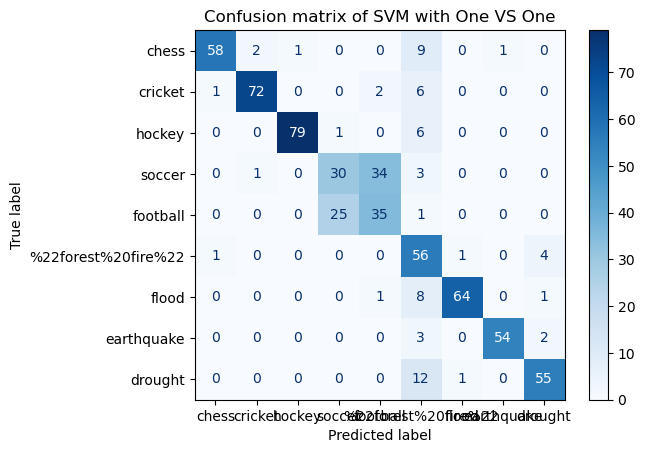

In [102]:
cm_plot_2(confusion_matrix_SVM_one, clf_multi, title="Confusion matrix of SVM with One VS One",x=my_list)

### SVM with One VS rest 

In [103]:
from sklearn.multiclass import OneVsRestClassifier
clf_multi_rest = OneVsRestClassifier(svm.SVC(kernel='linear', random_state=42),n_jobs=-1)
clf_multi_rest_predicted = clf_multi_rest.fit(train_LSI50, train.leaf_label).predict(test_LSI50)

In [104]:
score_table_leaf(test.leaf_label, clf_multi_rest_predicted, Name='SVM with One VS Rest')

,Score type,SVM with One VS Rest
0,Accuracy,0.825397
1,Recall,0.825397
2,Precision,0.826378
3,F1,0.824860


In [105]:
confusion_matrix_SVM_rest = metrics.confusion_matrix(test.leaf_label,clf_multi_rest_predicted,
                                                    labels = my_list)
print("confusion matrix of SVM with One VS Rest\nmulticlassification\n",
      confusion_matrix_SVM_rest)

confusion matrix of SVM with One VS Rest
multiclassification
 [[65  1  2  0  1  1  1  0  0]
 [ 1 77  0  0  1  0  1  1  0]
 [ 1  0 80  1  0  0  2  0  2]
 [ 1  0  1 31 34  0  0  0  1]
 [ 1  0  2 24 34  0  0  0  0]
 [ 2  0  0  0  0 54  0  0  6]
 [ 1  0  0  0  0  4 67  0  2]
 [ 1  0  0  0  0  2  0 54  2]
 [ 0  0  3  0  0  4  3  0 58]]


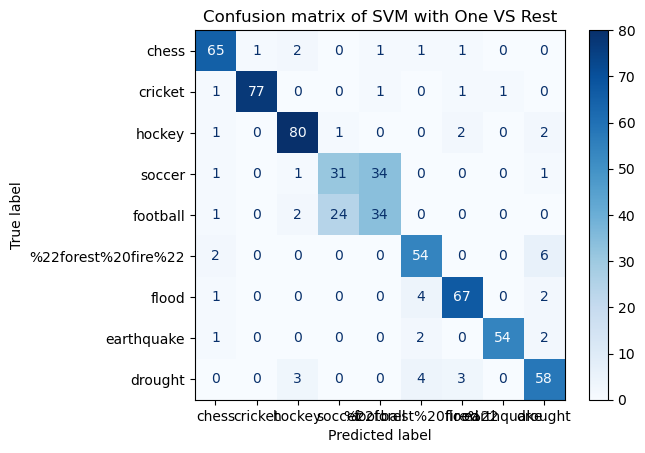

In [106]:
cm_plot_2(confusion_matrix_SVM_rest, clf_multi_rest, title="Confusion matrix of SVM with One VS Rest", x=my_list)

### Three confusion matrix is a 9 * 9 matrix. In each plot, there is a obvious square in the plot. Each matrix has a certain square range has high misclassification rate. 
### And there is distinct block on major diagonal. It shows that Naive Bayes model easily misclassify "soccer" and "football". 

## Subset of lables

### SVM with One VS One after merge

In [107]:
def merge(label):
    if label == "football" or label == "soccer":
        return "FS"
    else:
        return label
import copy

train_merge = copy.deepcopy(train)
test_merge = copy.deepcopy(test)

train_merge["leaf_label"] = train_merge["leaf_label"].apply(lambda x:merge(x))
test_merge["leaf_label"] = test_merge["leaf_label"].apply(lambda x:merge(x))

In [108]:
clf_merge_one_predicted = clf_multi.fit(train_LSI50, train_merge.leaf_label).predict(test_LSI50)

In [109]:
score_table_leaf(test_merge.leaf_label, clf_merge_one_predicted, 
                 Name='SVM with One VS One (after merge)')

,Score type,SVM with One VS One (after merge)
0,Accuracy,0.892063
1,Recall,0.892063
2,Precision,0.919588
3,F1,0.899371


In [110]:
map_row_to_class_2 = {0:"chess", 1:"cricket", 2:"hockey", 3:"FS",
                    4:"%22forest%20fire%22", 5:"flood", 6:"earthquake",
                    7:"drought"}
my_list_2 = list(map_row_to_class_2.values())

In [111]:
confusion_matrix_SVM_one_merge = metrics.confusion_matrix(test_merge.leaf_label,clf_merge_one_predicted,
                                                    labels = my_list_2)
print("confusion matrix of SVM with One VS One\nmerge multiclassification\n",
      confusion_matrix_SVM_one_merge)

confusion matrix of SVM with One VS One
merge multiclassification
 [[ 58   1   1   1   9   0   1   0]
 [  1  71   0   3   6   0   0   0]
 [  0   0  79   1   6   0   0   0]
 [  0   0   0 126   3   0   0   0]
 [  1   0   0   0  56   1   0   4]
 [  0   0   0   1   8  64   0   1]
 [  0   0   0   1   3   0  53   2]
 [  0   0   0   0  12   1   0  55]]


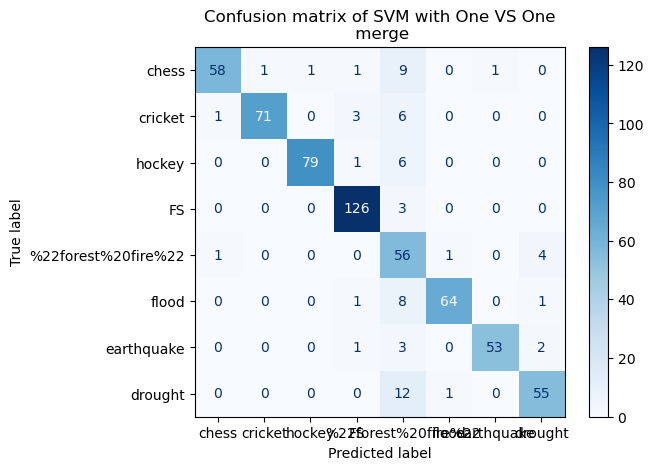

In [112]:
cm_plot_2(confusion_matrix_SVM_one_merge, clf_multi, 
          title="Confusion matrix of SVM with One VS One\n merge",x=my_list_2)

### SVM with One VS Rest after merge

In [113]:
clf_merge_rest_predicted = clf_multi_rest.fit(train_LSI50, train_merge.leaf_label).predict(test_LSI50)

In [114]:
score_table_leaf(test_merge.leaf_label, clf_merge_rest_predicted, 
                 Name='SVM with One VS Rest (after merge)')

,Score type,SVM with One VS Rest (after merge)
0,Accuracy,0.917460
1,Recall,0.917460
2,Precision,0.918946
3,F1,0.917767


In [115]:
confusion_matrix_SVM_rest_merge = metrics.confusion_matrix(test_merge.leaf_label,clf_merge_rest_predicted,
                                                    labels = my_list_2)
print("confusion matrix of SVM with One VS Rest\nmerge multiclassification\n",
      confusion_matrix_SVM_rest_merge)

confusion matrix of SVM with One VS Rest
merge multiclassification
 [[ 65   2   2   0   1   1   0   0]
 [  1  75   0   3   0   1   1   0]
 [  0   0  80   2   0   2   0   2]
 [  0   0   1 127   0   0   0   1]
 [  2   0   0   1  53   0   0   6]
 [  0   0   0   1   4  67   0   2]
 [  1   0   0   1   2   0  53   2]
 [  0   0   3   0   4   3   0  58]]


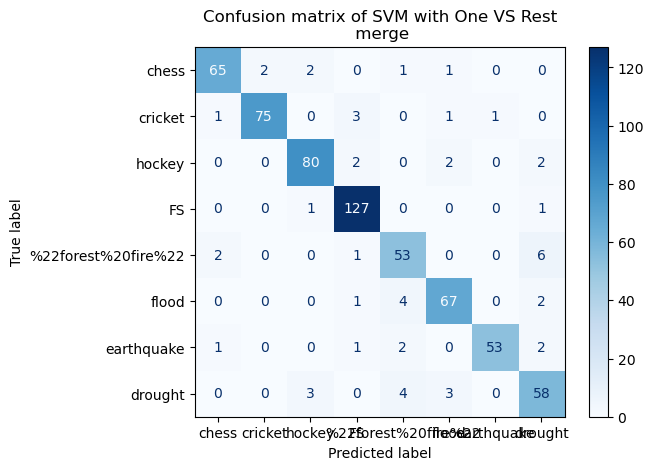

In [116]:
cm_plot_2(confusion_matrix_SVM_rest_merge, clf_multi, 
          title="Confusion matrix of SVM with One VS Rest\n merge",x=my_list_2)

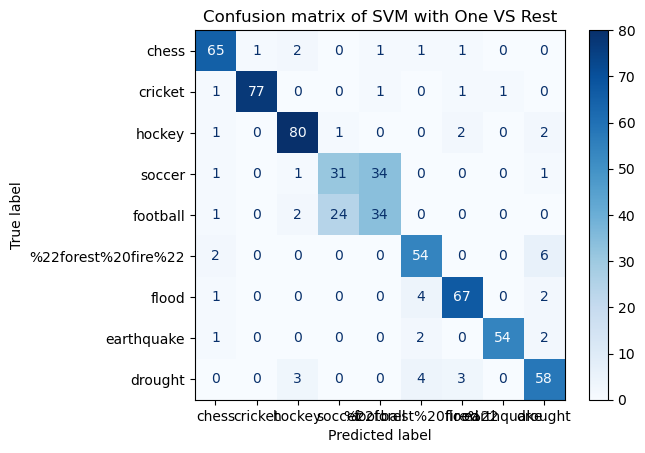

In [117]:
cm_plot_2(confusion_matrix_SVM_rest, clf_multi_rest, title="Confusion matrix of SVM with One VS Rest", x=my_list)

### Accuracy improved a lot compare with before merge labels. 

## Class imbalance

### After merge, SVM is more accurate on classifying other labels except the merge label, "FS". 
### To solve imbalanced classes, we added a parameter in SVM model.

### SVM with One VS One after balanced

In [118]:
clf_multi_balance = OneVsOneClassifier(svm.SVC(kernel='linear', random_state=42,
                                              class_weight = "balanced"),n_jobs=-1)
clf_balance_predicted = clf_multi_balance.fit(train_LSI50, train_merge.leaf_label).predict(test_LSI50)

In [119]:
score_table_leaf(test_merge.leaf_label, clf_balance_predicted, 
                 Name='SVM with One VS One (after balance)')

,Score type,SVM with One VS One (after balance)
0,Accuracy,0.892063
1,Recall,0.892063
2,Precision,0.917786
3,F1,0.899367


In [120]:
confusion_matrix_SVM_one_balance = metrics.confusion_matrix(test_merge.leaf_label,clf_balance_predicted,
                                                    labels = my_list_2)
print("confusion matrix of SVM with One VS One\nbalanced multiclassification\n",
      confusion_matrix_SVM_one_balance)

confusion matrix of SVM with One VS One
balanced multiclassification
 [[ 59   2   1   0   9   0   0   0]
 [  2  73   0   2   4   0   0   0]
 [  0   0  79   1   6   0   0   0]
 [  2   1   0 122   4   0   0   0]
 [  1   0   0   0  56   1   0   4]
 [  0   0   0   1   8  64   0   1]
 [  0   0   0   0   3   0  54   2]
 [  0   0   0   0  12   1   0  55]]


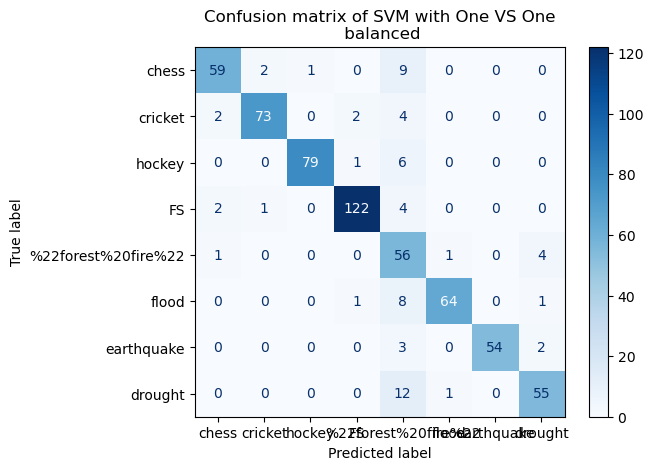

In [121]:
cm_plot_2(confusion_matrix_SVM_one_balance, clf_multi_balance, 
          title="Confusion matrix of SVM with One VS One\n balanced",x=my_list_2)

### SVM with One VS Rest after balaned

In [122]:
clf_balance_rest = OneVsRestClassifier(svm.SVC(kernel='linear', random_state=42,
                                              class_weight = "balanced"),n_jobs=-1)
clf_balance_rest_predicted = clf_balance_rest.fit(train_LSI50, train_merge.leaf_label).predict(test_LSI50)

In [123]:
score_table_leaf(test_merge.leaf_label, clf_balance_rest_predicted, 
                 Name='SVM with One VS Rest (after balance)')

,Score type,SVM with One VS Rest (after balance)
0,Accuracy,0.914286
1,Recall,0.914286
2,Precision,0.922257
3,F1,0.915762


In [124]:
confusion_matrix_SVM_rest_balance = metrics.confusion_matrix(test_merge.leaf_label,clf_balance_rest_predicted,
                                                    labels = my_list_2)
print("confusion matrix of SVM with One VS Rest\nbalanced multiclassification\n",
      confusion_matrix_SVM_rest_balance)

confusion matrix of SVM with One VS Rest
balanced multiclassification
 [[ 61   2   2   0   6   0   0   0]
 [  1  76   2   2   0   0   0   0]
 [  3   0  81   1   1   0   0   0]
 [  0   0   0 126   3   0   0   0]
 [  0   0   0   0  58   1   1   2]
 [  1   0   1   0   5  64   1   2]
 [  0   0   0   0   1   0  56   2]
 [  2   0   2   0   9   1   0  54]]


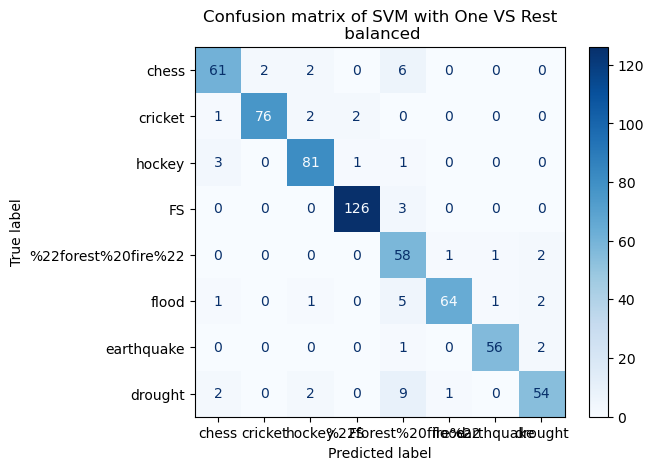

In [125]:
cm_plot_2(confusion_matrix_SVM_rest_balance, clf_balance_rest, 
          title="Confusion matrix of SVM with One VS Rest\n balanced",x=my_list_2)

# Question 10

Co-occurrence probabilities perform better than individual probabilities. The ratio is easier to distinguish relevant words from irrelevant words. It’s also better to discriminate between two relevant words. Because the ratio of co-occurrence probabilities can help better distinguish relevant words from irrelevant words and can help distinguish one word from another given two relevant words

Yes, because the co-occurence of other words in the context of running is same for both sentences. Running here has two different meanings. For “James is running in the park” , running means moving at a fast speed. But for the second sentence, “James is running for presidency”, running means persuading or competing in an election. But for GLoVE embedding, it cares about co-occurrence between word and word. One vector can only represent one meaning. If it wants to show more meaning, then it will need more vectors. The relationship between running and other words in two sentences are the same. 

The value ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] +GLoVE["husband"]||2 should be highest since the analogy of queen to king to wife to husband is not as similar compared to the other two, and thus has the highest value. The value of ||GLoVE["queen"] - GLoVE["king"]||2 is the second highest because queen is similar to king but not as similar as the analogy of wife and husband The value of ||GLoVE["wife"] - GLoVE["husband"]||2 should be lowest because wife and husband are the most similar to each other. 

I would rather lemmatize the word before mapping it to GLoVE embedding because it is possible that stemming will cause same words of different form (like see and saw) to be considered as different words and this will affect the ratio of co-occurrence probabilities of a word in the context of another word. Lemmatization keeps more information on words. Then, GLoVE will process more informatively and output the train data. 


# Question 11

In [126]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [127]:
from numpy import linalg as LA

In [128]:
Glove_train = []
for news in df_trainLe:
    su = [0]*300
    for words in nltk.word_tokenize(news):
        if words in embeddings_dict:
            su+=embeddings_dict[words]
    if LA.norm(su)!=0:
        su/=LA.norm(su)
    Glove_train.append(su)

Glove_test = []
for news in df_testLe:
    su = [0]*300
    for words in nltk.word_tokenize(news):
        if words in embeddings_dict:
            su+=embeddings_dict[words]
    if LA.norm(su)!=0:
        su/=LA.norm(su)
    Glove_test.append(su)

In [129]:
len(Glove_train)

2520

In [130]:
pipe_glove = Pipeline(steps=[
                       ('Reduction', LogisticRegression(solver='liblinear',random_state=42))], memory=cachedir)
param_grid_glove = {
    'Reduction__penalty': ['l1','l2'],
    'Reduction__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
    }

search_com_glove = GridSearchCV(pipe_glove,cv=5,param_grid=param_grid_glove,scoring='accuracy',n_jobs=-1)

In [131]:
search_com_glove.fit(Glove_train,train.root_label)

GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/tmp82wed18x',
                                steps=[('Reduction',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'Reduction__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                          10, 100, 1000, 10000, 100000],
                         'Reduction__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [132]:
search_com_glove.best_params_

{'Reduction__C': 10, 'Reduction__penalty': 'l1'}

In [133]:
pd.DataFrame(search_com_glove.cv_results_).sort_values(by='mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Reduction__C,param_Reduction__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.294961,0.128276,0.001248,0.000192,10,l1,"{'Reduction__C': 10, 'Reduction__penalty': 'l1'}",0.940476,0.962302,0.964286,0.950397,0.950397,0.953571,0.008748,1
15,0.152510,0.013576,0.001262,0.000168,100,l2,"{'Reduction__C': 100, 'Reduction__penalty': 'l2'}",0.934524,0.956349,0.968254,0.948413,0.952381,0.951984,0.010968,2
13,0.075443,0.007762,0.001164,0.000240,10,l2,"{'Reduction__C': 10, 'Reduction__penalty': 'l2'}",0.940476,0.960317,0.958333,0.950397,0.942460,0.950397,0.008035,3
17,0.308703,0.054553,0.001167,0.000236,1000,l2,"{'Reduction__C': 1000, 'Reduction__penalty': '...",0.934524,0.956349,0.966270,0.950397,0.936508,0.948810,0.011997,4
20,1.220301,0.112138,0.001046,0.000157,100000,l1,"{'Reduction__C': 100000, 'Reduction__penalty':...",0.936508,0.952381,0.960317,0.954365,0.932540,0.947222,0.010766,5
18,1.120832,0.253798,0.001239,0.000223,10000,l1,"{'Reduction__C': 10000, 'Reduction__penalty': ...",0.932540,0.954365,0.960317,0.950397,0.934524,0.946429,0.011011,6
16,1.686241,0.158199,0.001391,0.000536,1000,l1,"{'Reduction__C': 1000, 'Reduction__penalty': '...",0.928571,0.960317,0.960317,0.952381,0.930556,0.946429,0.014086,6
14,0.869460,0.320167,0.001444,0.000273,100,l1,"{'Reduction__C': 100, 'Reduction__penalty': 'l1'}",0.932540,0.958333,0.960317,0.944444,0.934524,0.946032,0.011597,8
19,0.431428,0.067107,0.001182,0.000140,10000,l2,"{'Reduction__C': 10000, 'Reduction__penalty': ...",0.924603,0.956349,0.962302,0.946429,0.932540,0.944444,0.014142,9
21,0.466364,0.048829,0.001467,0.000441,100000,l2,"{'Reduction__C': 100000, 'Reduction__penalty':...",0.924603,0.954365,0.960317,0.946429,0.930556,0.943254,0.013666,10


In [134]:
Logistic_r_glove = LogisticRegression(penalty='l2',C=100,solver='liblinear',random_state=42)
Logistic_r_glove.fit(Glove_train,train.root_label)

LogisticRegression(C=100, random_state=42, solver='liblinear')

In [135]:
accur=[]
accur.append(accuracy_score(test.root_label, Logistic_r_glove.predict(Glove_test)))
score_table_root(test.root_label, 
                 Logistic_r_glove.predict(Glove_test),
                 Name='GLoVE')

,Score type,GLoVE
0,Accuracy,0.958730
1,Recall,0.956403
2,Precision,0.972299
3,F1,0.964286


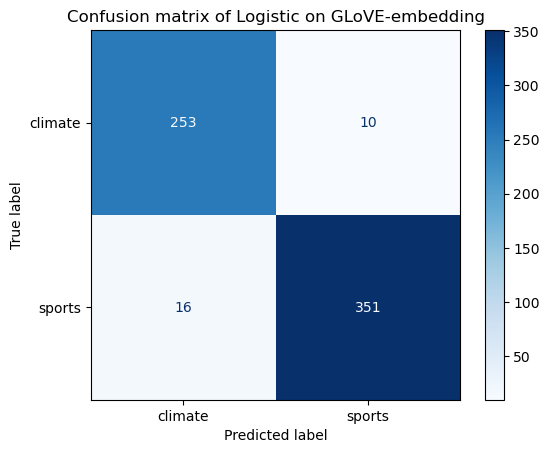

In [136]:
confusion_matrix_glove=metrics.confusion_matrix(test.root_label, 
                                                Logistic_r_glove.predict(Glove_test))
cm_plot_2(confusion_matrix_glove, Logistic_r_glove, x=Logistic_r_glove.classes_,
          title="Confusion matrix of Logistic on GLoVE-embedding")

# Question 12

In [137]:
embeddings_dict_200 = {}
dimension_of_glove = 200
with open("glove/glove.6B.200d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict_200[word] = vector

In [138]:
embeddings_dict_100 = {}
dimension_of_glove = 100
with open("glove/glove.6B.100d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict_100[word] = vector

In [139]:
embeddings_dict_50 = {}
dimension_of_glove = 50
with open("glove/glove.6B.50d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict_50[word] = vector

In [140]:
Glove_train_200 = []
for news in df_trainLe:
    su = [0]*200
    for words in nltk.word_tokenize(news):
        if words in embeddings_dict_200:
            su+=embeddings_dict_200[words]
    if LA.norm(su)!=0:
        su/=LA.norm(su)
    Glove_train_200.append(su)

Glove_test_200 = []
for news in df_testLe:
    su = [0]*200
    for words in nltk.word_tokenize(news):
        if words in embeddings_dict_200:
            su+=embeddings_dict_200[words]
    if LA.norm(su)!=0:
        su/=LA.norm(su)
    Glove_test_200.append(su)

In [141]:
Glove_train_100 = []
for news in df_trainLe:
    su = [0]*100
    for words in nltk.word_tokenize(news):
        if words in embeddings_dict_100:
            su+=embeddings_dict_100[words]
    if LA.norm(su)!=0:
        su/=LA.norm(su)
    Glove_train_100.append(su)

Glove_test_100 = []
for news in df_testLe:
    su = [0]*100
    for words in nltk.word_tokenize(news):
        if words in embeddings_dict_100:
            su+=embeddings_dict_100[words]
    if LA.norm(su)!=0:
        su/=LA.norm(su)
    Glove_test_100.append(su)

In [142]:
Glove_train_50 = []
for news in df_trainLe:
    su = [0]*50
    for words in nltk.word_tokenize(news):
        if words in embeddings_dict_50:
            su+=embeddings_dict_50[words]
    if LA.norm(su)!=0:
        su/=LA.norm(su)
    Glove_train_50.append(su)

Glove_test_50 = []
for news in df_testLe:
    su = [0]*50
    for words in nltk.word_tokenize(news):
        if words in embeddings_dict_50:
            su+=embeddings_dict_50[words]
    if LA.norm(su)!=0:
        su/=LA.norm(su)
    Glove_test_50.append(su)

In [143]:

Logistic_r_glove_200 = LogisticRegression(penalty='l1',C=1000,solver='liblinear',random_state=42)
Logistic_r_glove_200.fit(Glove_train_200,train.root_label)
print("Accuracy of 200d")
accur.append(accuracy_score(test.root_label, Logistic_r_glove_200.predict(Glove_test_200)))
print(accur[1])

Accuracy of 200d
0.9555555555555556


In [144]:
Logistic_r_glove_100 = LogisticRegression(penalty='l1',C=1000,solver='liblinear',random_state=42)
Logistic_r_glove_100.fit(Glove_train_100,train.root_label)
print("Accuracy of 100d")
accur.append(accuracy_score(test.root_label, Logistic_r_glove_100.predict(Glove_test_100)))
print(accur[2])

Accuracy of 100d
0.9476190476190476


In [145]:
Logistic_r_glove_50 = LogisticRegression(penalty='l1',C=1000,solver='liblinear',random_state=42)
Logistic_r_glove_50.fit(Glove_train_50,train.root_label)
print("Accuracy of 50d")
accur.append(accuracy_score(test.root_label, Logistic_r_glove_50.predict(Glove_test_50)))
print(accur[3])

Accuracy of 50d
0.9444444444444444


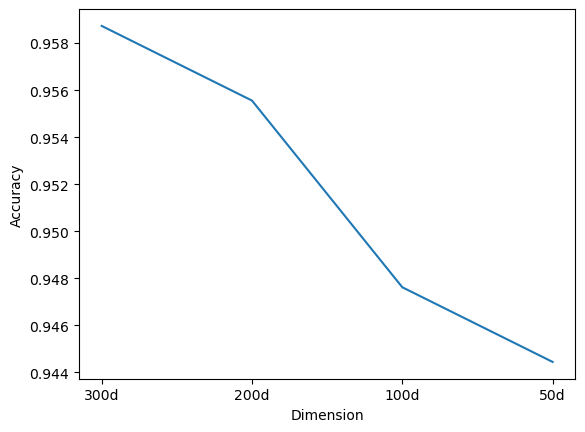

In [146]:
plt.xlabel("Dimension")
plt.ylabel("Accuracy")
plt.plot(["300d","200d","100d",'50d'],accur)
plt.show()

# Question 13

In [147]:
import umap
import umap.plot

In [148]:
graph = umap.UMAP().fit(Glove_train)

<AxesSubplot:>

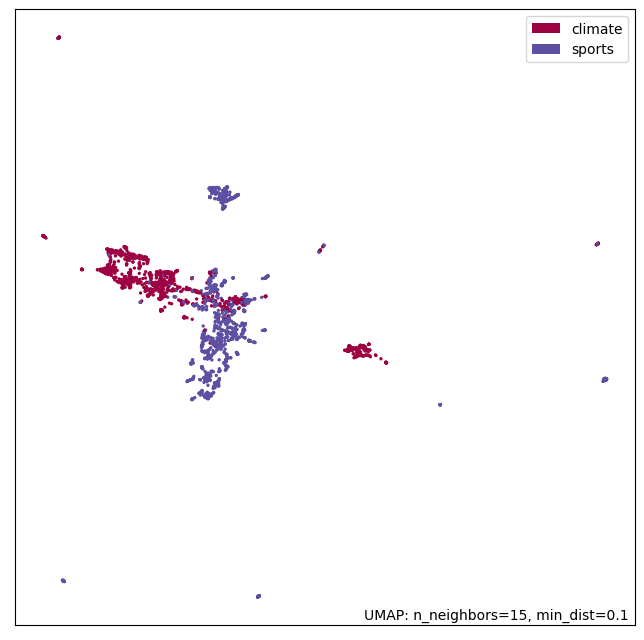

In [149]:
umap.plot.points(graph,labels = train.root_label)

In [150]:
rand_matrix = np.random.rand(len(Glove_train),300)
for x in range(len(rand_matrix)):
    rand_matrix[x] = rand_matrix[x]/LA.norm(rand_matrix[x])

<AxesSubplot:>

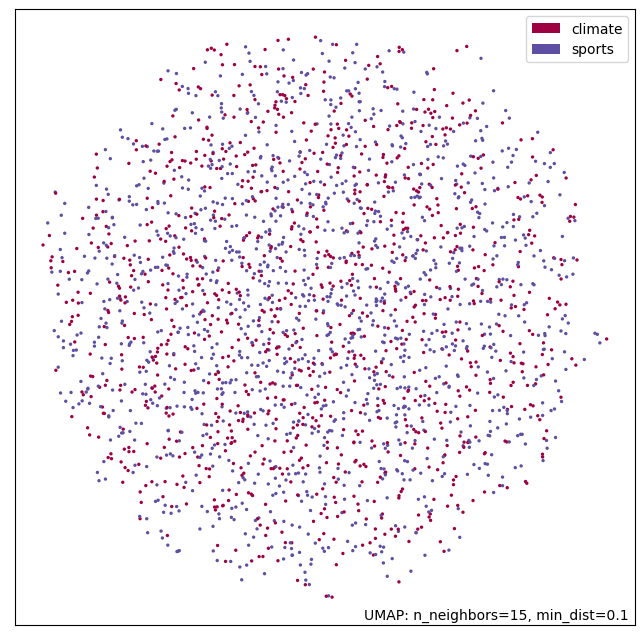

In [151]:
graph_rand = umap.UMAP().fit(rand_matrix)
umap.plot.points(graph_rand,labels = train.root_label)